In [31]:
from pathlib import Path

MLRUNS_DIR = Path().absolute().parents[1] / "mlruns"
MLRUNS_DIR

PosixPath('/home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-ml/mlruns')

In [32]:
import mlflow

mlflow.set_tracking_uri(f"sqlite:///{MLRUNS_DIR}/mlflow.db")
mlflow.set_experiment("custom-layer")

<Experiment: artifact_location='/home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-ml/handson_ml/chapter_12/mlruns/1', creation_time=1698954400557, experiment_id='1', last_update_time=1698954400557, lifecycle_stage='active', name='custom-layer', tags={}>

In [33]:
from pathlib import Path
from time import strftime

PROJ_ROOT = Path().absolute()
MODEL_DIR = PROJ_ROOT / "models"
LOG_DIR = PROJ_ROOT / "logs"


def get_run_dir(root_dir, name="run"):
    return Path(root_dir) / f"{name}-{strftime('%Y_%m_%d-%H_%M_%S')}"

In [34]:
from tensorflow import keras

keras.utils.set_random_seed(42)
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

## Custom implementation of `LayerNormalization`

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model


@keras.saving.register_keras_serializable(package="CustomLayer")
class CustomLayerNormalization(keras.layers.Layer):
    def __init__(self, eps=10e-3, **kwargs):
        super().__init__(**kwargs)
        self._eps = eps

    def build(self, batch_input_shape):
        self._alpha = self.add_weight(
            shape=batch_input_shape[-1:], initializer="ones", name="alpha"
        )
        self._beta = self.add_weight(
            shape=batch_input_shape[-1:], initializer="zeros", name="beta"
        )

    def call(self, X):
        mean, var = tf.nn.moments(X, axes=-1, keepdims=True)
        return self._alpha * (X - mean) / tf.sqrt(var + self._eps) + self._beta

    def get_config(self):
        base_config = super().get_config()
        return base_config | {"eps": self._eps}

In [7]:
epochs = 100
batch_size = 128
val_split = 0.2
optimizer = "adam"
loss = "sparse_categorical_crossentropy"
run = "custom_layer"

mlflow.tensorflow.autolog()

custom_layernet = keras.Sequential(
    [
        (norm := keras.layers.Normalization(input_shape=X_train.shape[-2:])),
        keras.layers.Flatten(),
        keras.layers.Dense(50, activation="swish", kernel_initializer="he_normal"),
        CustomLayerNormalization(),
        keras.layers.Dense(30, activation="swish", kernel_initializer="he_normal"),
        CustomLayerNormalization(),
        keras.layers.Dense(10, activation="softmax"),
    ]
)
custom_layernet.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

norm.adapt(X_train)
history = custom_layernet.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5),
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        # keras.callbacks.ModelCheckpoint(
        #     str(get_run_dir(MODEL_DIR, name=run)), patience=10, save_best_only=True
        # ),
        # keras.callbacks.TensorBoard(log_dir=str(get_run_dir(LOG_DIR, name=run))),
    ],
)

2023/11/03 01:32:05 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2023-11-03 01:32:05.234368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 01:32:05.248655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 01:32:05.248760: I tensorflow/compiler/xla/stream_executor/cuda/c

Epoch 1/100


2023-11-03 01:32:07.083911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-03 01:32:07.092308: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ffd6e69e520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-03 01:32:07.092329: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-11-03 01:32:07.094415: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-03 01:32:07.100693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2023-11-03 01:32:07.157781: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

  1/375 [..............................] - ETA: 5:31 - loss: 2.8595 - accuracy: 0.0938

WARNI [tensorflow] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_train_batch_end` time: 0.0020s). Check your callbacks.


375/375 [==============================] - 2s 3ms/step - loss: 0.5608 - accuracy: 0.8111 - val_loss: 0.4127 - val_accuracy: 0.8535 - lr: 0.0010
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3726 - accuracy: 0.8680 - val_loss: 0.3747 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3310 - accuracy: 0.8812 - val_loss: 0.3583 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 4/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3024 - accuracy: 0.8909 - val_loss: 0.3418 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2821 - accuracy: 0.8964 - val_loss: 0.3385 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2652 - accuracy: 0.9042 - val_loss: 0.3350 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 0

2023/11/03 01:32:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/.micromamba/envs/homl/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


### Verifying with the `keras` implementation of `LayerNormalization`

In [10]:
tf.reduce_mean(
    keras.metrics.mean_squared_error(
        keras.layers.LayerNormalization()(X_train.astype("float32")),
        CustomLayerNormalization()(X_train.astype("float32")),
    )
)

<tf.Tensor: shape=(), dtype=float32, numpy=4.7628e-06>

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

epochs = 20
batch_size = 128
val_split = 0.2
optimizer = "adam"
loss = "sparse_categorical_crossentropy"
run = "custom_layer"

# mlflow.tensorflow.autolog()

layernet = keras.Sequential(
    [
        (norm := keras.layers.Normalization(input_shape=X_train.shape[-2:])),
        keras.layers.Flatten(),
        keras.layers.Dense(50, activation="swish", kernel_initializer="he_normal"),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(30, activation="swish", kernel_initializer="he_normal"),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(10, activation="softmax"),
    ]
)
layernet.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

norm.adapt(X_train)
k_history = layernet.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=[
        # keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5),
        # keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        # keras.callbacks.ModelCheckpoint(
        #     str(get_run_dir(MODEL_DIR, name=run)), patience=10, save_best_only=True
        # ),
        # keras.callbacks.TensorBoard(log_dir=str(get_run_dir(LOG_DIR, name=run))),
    ],
)

Epoch 1/20
375/375 [==============================] - 2s 3ms/step - loss: 0.5608 - accuracy: 0.8113 - val_loss: 0.4127 - val_accuracy: 0.8536
Epoch 2/20
375/375 [==============================] - 1s 4ms/step - loss: 0.3726 - accuracy: 0.8681 - val_loss: 0.3748 - val_accuracy: 0.8653
Epoch 3/20
375/375 [==============================] - 1s 3ms/step - loss: 0.3310 - accuracy: 0.8812 - val_loss: 0.3582 - val_accuracy: 0.8683
Epoch 4/20
375/375 [==============================] - 1s 2ms/step - loss: 0.3024 - accuracy: 0.8909 - val_loss: 0.3421 - val_accuracy: 0.8773
Epoch 5/20
375/375 [==============================] - 1s 3ms/step - loss: 0.2822 - accuracy: 0.8965 - val_loss: 0.3389 - val_accuracy: 0.8801
Epoch 6/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2653 - accuracy: 0.9042 - val_loss: 0.3352 - val_accuracy: 0.8779
Epoch 7/20
375/375 [==============================] - 1s 3ms/step - loss: 0.2543 - accuracy: 0.9069 - val_loss: 0.3423 - val_accuracy: 0.8799
Epoch 

In [53]:
k_history.history

{'loss': [0.5607707500457764,
  0.3726051449775696,
  0.3310035765171051,
  0.3024294078350067,
  0.2822059392929077,
  0.26529473066329956,
  0.25428107380867004,
  0.2389880120754242,
  0.2287013679742813,
  0.21906635165214539,
  0.20986118912696838,
  0.20031577348709106,
  0.19422847032546997,
  0.18816156685352325,
  0.17959114909172058,
  0.17462316155433655,
  0.16771700978279114,
  0.16340011358261108,
  0.15965190529823303,
  0.15441833436489105],
 'accuracy': [0.8112916946411133,
  0.8681250214576721,
  0.8812083601951599,
  0.890874981880188,
  0.8964999914169312,
  0.9041666388511658,
  0.9069374799728394,
  0.9129166603088379,
  0.9164583086967468,
  0.9193124771118164,
  0.9227916598320007,
  0.9256874918937683,
  0.9291458129882812,
  0.9304999709129333,
  0.9328333139419556,
  0.9349374771118164,
  0.9383958578109741,
  0.9401458501815796,
  0.9407291412353516,
  0.9433749914169312],
 'val_loss': [0.41270744800567627,
  0.3747941553592682,
  0.35820460319519043,
  0.34

## Custom training loop for Fashion MNIST

In [58]:
from sys import stdout

import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm


def train(
    model,
    X,
    y,
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=None,
    epochs=20,
    batch_size=64,
    validation_split=None,
):
    def _print_status_bar(step, total, loss, metrics=None, val=False):
        metrics = " - ".join(
            [
                f"{metric.name}: {metric.result():.4f}"
                for metric in [loss] + (metrics or [])
            ]
        )
        end = "" if val or step < total else "\n"
        print(f"\r{step}/{total} - {metrics}", end=end)

    keras.utils.set_random_seed(42)
    optimizer = keras.optimizers.get(optimizer)
    loss = keras.losses.get(loss)
    sp_cat_ce = keras.metrics.SparseCategoricalCrossentropy()
    metrics = metrics or [keras.metrics.SparseCategoricalAccuracy()]
    history = {"loss": []} | {m.name: [] for m in metrics}

    if validation_split is not None:
        val_idx = tf.cast(
            tf.math.ceil(y.shape[0] * validation_split), dtype=tf.int32
        ).numpy()
        X_valid, y_valid = X[-val_idx:], y[-val_idx:]
        X_train, y_train = X[:-val_idx], y[:-val_idx]
        val_batches = tf.cast(
            tf.math.ceil(y_valid.shape[0] / batch_size), dtype=tf.int32
        )

        history = history | {"val_loss": []} | {f"val_{m.name}": [] for m in metrics}
    else:
        X_train, y_train = X, y
    train_batches = tf.cast(tf.math.ceil(y_train.shape[0] / batch_size), dtype=tf.int32)

    for i in tf.range(epochs, dtype=tf.int32):
        train_idx = tf.random.shuffle(tf.range(y_train.shape[0]))
        X_train, y_train = X_train[train_idx], y_train[train_idx]

        for j in tqdm(
            tf.range(train_batches, dtype=tf.int32),
            ncols=70,
            desc=f"Epoch {i + 1}/{epochs}",
            file=stdout,
            postfix={"loss": sp_cat_ce.result().numpy()}
            | {m.name: m.result().numpy() for m in metrics},
        ):
            X_batch, y_batch = (
                tf.constant(
                    X_train[j.numpy() * batch_size : (j.numpy() + 1) * batch_size]
                ),
                tf.constant(
                    y_train[j.numpy() * batch_size : (j.numpy() + 1) * batch_size]
                ),
            )

            with tf.GradientTape() as tape:
                y_pred = model(X_batch, training=True)
                loss_val = tf.add_n([loss(y_batch, y_pred)] + model.losses)

            gradients = tape.gradient(loss_val, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

            sp_cat_ce(y_batch, y_pred)
            for metric in metrics:
                metric(y_batch, y_pred)

            # _print_status_bar(
            #     j + 1, train_batches, sp_cat_ce, metrics, val=bool(validation_split)
            # )

        history["loss"].append(sp_cat_ce.result().numpy())
        sp_cat_ce.reset_states()
        for metric in metrics:
            history[metric.name].append(metric.result().numpy())
            metric.reset_states()

        if validation_split is not None:
            for j in tf.range(val_batches, dtype=tf.int32):
                X_batch, y_batch = (
                    tf.constant(
                        X_valid[j.numpy() * batch_size : (j.numpy() + 1) * batch_size]
                    ),
                    tf.constant(
                        y_valid[j.numpy() * batch_size : (j.numpy() + 1) * batch_size]
                    ),
                )
                y_pred = model(X_batch, training=False)
                loss_val = loss(y_batch, y_pred)

                sp_cat_ce(y_batch, y_pred)
                for metric in metrics:
                    metric(y_batch, y_pred)

            print(
                " - ".join(
                    [f"val_{m.name}: {m.result():.4f}" for m in [sp_cat_ce] + metrics]
                )
            )

            history["val_loss"].append(sp_cat_ce.result().numpy())
            sp_cat_ce.reset_states()
            for metric in metrics:
                history[f"val_{metric.name}"].append(metric.result().numpy())
                metric.reset_states()

    return history

In [59]:
layernet = keras.Sequential(
    [
        (norm := keras.layers.Normalization(input_shape=X_train.shape[-2:])),
        keras.layers.Flatten(),
        keras.layers.Dense(50, activation="swish", kernel_initializer="he_normal"),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(30, activation="swish", kernel_initializer="he_normal"),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

norm.adapt(X_train)
history = train(layernet, X_train, y_train, batch_size=128, validation_split=0.2)



Epoch 1/20:   0%| | 0/375 [00:00<?, ?it/s, loss=0, sparse_categorical_

Epoch 1/20:   0%| | 1/375 [00:00<03:08,  1.99it/s, loss=0, sparse_cate

Epoch 1/20:   3%| | 13/375 [00:00<00:13, 27.65it/s, loss=0, sparse_cat

Epoch 1/20:   6%| | 24/375 [00:00<00:07, 46.76it/s, loss=0, sparse_cat

Epoch 1/20:   9%| | 35/375 [00:00<00:05, 62.29it/s, loss=0, sparse_cat

Epoch 1/20:  13%|▏| 47/375 [00:00<00:04, 75.82it/s, loss=0, sparse_cat

Epoch 1/20:  16%|▏| 59/375 [00:01<00:03, 87.62it/s, loss=0, sparse_cat

Epoch 1/20:  19%|▏| 71/375 [00:01<00:03, 95.37it/s, loss=0, sparse_cat

Epoch 1/20:  22%|▏| 82/375 [00:01<00:02, 99.28it/s, loss=0, sparse_cat

Epoch 1/20:  25%|▎| 94/375 [00:01<00:02, 104.97it/s, loss=0, sparse_ca

Epoch 1/20:  28%|▎| 106/375 [00:01<00:02, 94.64it/s, loss=0, sparse_ca

Epoch 1/20:  31%|▎| 117/375 [00:01<00:02, 96.41it/s, loss=0, sparse_ca

Epoch 1/20:  34%|▎| 128/375 [00:01<00:02, 98.77it/s, loss=0, sparse_ca

Epoch 1/20:  37%|▎| 139/375 [00:01<00:02, 101.40it/s, loss=0, 

In [57]:
history

{'loss': [0.5479386,
  0.3707395,
  0.32894552,
  0.29789656,
  0.27789783,
  0.26370993,
  0.25058857,
  0.23447211,
  0.22397654,
  0.2166279,
  0.20688784,
  0.19896041,
  0.19093052,
  0.18405174,
  0.17913438,
  0.17199881,
  0.16229093,
  0.15825805,
  0.15483214,
  0.15020931],
 'sparse_categorical_accuracy': [0.8146875,
  0.86920834,
  0.88091666,
  0.8920417,
  0.8985625,
  0.9035,
  0.9066667,
  0.913,
  0.91672915,
  0.91854167,
  0.92347914,
  0.9262083,
  0.9287292,
  0.9338958,
  0.934625,
  0.9375833,
  0.9406875,
  0.94177085,
  0.943375,
  0.944],
 'val_loss': [0.42178747,
  0.36912334,
  0.35273007,
  0.34681466,
  0.33762816,
  0.34685254,
  0.33126304,
  0.34104615,
  0.327528,
  0.35469392,
  0.33390984,
  0.34005487,
  0.36152437,
  0.3451695,
  0.38532874,
  0.36880067,
  0.36949325,
  0.39591548,
  0.38393453,
  0.39359608],
 'val_sparse_categorical_accuracy': [0.8509167,
  0.8678333,
  0.87058336,
  0.87341666,
  0.87916666,
  0.87733334,
  0.88075,
  0.8789167

In [67]:
import cudf as cd

khist = cd.DataFrame(k_history.history)
hist = cd.DataFrame(history).rename(columns=dict(zip(hist.columns, khist.columns)))

Text(0.5, 1.0, 'Keras fit vs custom training loop')

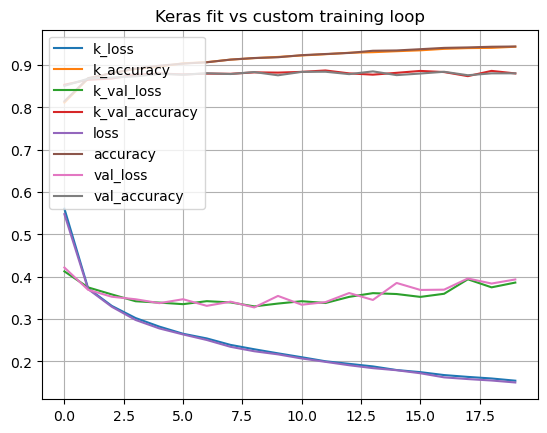

In [80]:
ax = khist.rename(columns=lambda c: f"k_{c}").to_pandas().plot()
hist.to_pandas().plot(ax=ax)
ax.grid(True)
ax.legend(loc="upper left")
ax.set_title("Keras fit vs custom training loop")

In [1]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

2023-11-02 10:03:20.513623: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 10:03:20.531512: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[]